In [1]:
import numpy as np
import pandas as pd
from pandas import json_normalize

import requests
import json

from geopy.geocoders import Nominatim
from IPython.display import Image 
from IPython.core.display import HTML     
import folium
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist 


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

<h4>Import Neighborhood Data</h4>
<p>This data was found from
<a href="https://opendata.arcgis.com/datasets/7c5e82ef83834de2ad2478efc86744ae_0.geojson">opendata</a></p>
<p>I processed the data to create the data frame within <a href="https://github.com/travistheall/Coursera_Capstone/blob/master/Python%20Files/neighborhoodDfCreate.py">neighborhoodDfCreate.py</a></p>
<p>I exported the data frame to an <a href="https://github.com/travistheall/Coursera_Capstone/tree/master/data/Geolocation">excel file</a> for ease of viewing and loaded it using pandas</p>
<p>Using the excel file I went to <a href="https://www.zillow.com/baton-rouge-la/home-values/
">Zillow</a>. Here I found the housing indexes for each neighborhood. The neighborhoods not found on Zillow were left blank.</p>

In [2]:
neighCenterData = pd.read_excel('../data/Geolocation/NeighborhoodMaxMinCenter.xlsx')
indexs = neighCenterData.where(neighCenterData['Zillow Home Value Index']=='Null').dropna()['Zillow Home Value Index'].index
for i in indexs:
    neighCenterData.at[i, 'Zillow Home Value Index']=np.NaN

<h4>Center of Baton Rouge Latitude and Longitude</h4>
<p>In order for Folium to load in a decent spot I found the center point of baton rouge</p>

In [3]:
brMaxLatX = neighCenterData["Max Latitude"].max()
brMinLatX = neighCenterData["Min Latitude"].min()
brMaxLongY = neighCenterData["Max Longitude"].max()
brMinLongY = neighCenterData["Min Longitude"].min()

brCenterLat = np.add(brMinLatX, np.divide(np.subtract(brMaxLatX, brMinLatX), 2))
brCenterLong = np.add(brMinLongY, np.divide(np.subtract(brMaxLongY, brMinLongY), 2))

<h4>Foursquare API</h4>
<p>Here we are searching the foursquare API for the various neighborhoods. The centers are being used as the latitudes and longitude coordinates along with the radius calculated from the <a href="https://github.com/travistheall/Coursera_Capstone/blob/master/Python%20Files/neighborhoodDfCreate.py">neighborhoodDfCreate.py</a></p>
<p>I sorted these by popularity and limited the number to only the top 10 restaurants in each neighborhood. The results are then put into a pandas dataframe</p>

In [4]:
CLIENT_ID='XLQ4AOQ1EPWQSLRZTS2J253I2KIEUF5QOIC3TEQ2T2HKCQIW'
CLIENT_SECRET = 'CZ2KUW1Z2FQ2VI3B5AOUTXNKL3BWPBODJ2XVEYCBPUZQZ3AR'

def getNearbyVenues(names, radius, latitudes, longitudes):
    section = 'food'
    sortByPopularity = 1
    VERSION = '20200805'
    LIMIT = 10
    venues_list = []
    for name, radius, lat, lng in zip(names, radius, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section={}&limit={}&sortByPopularity={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            section,
            LIMIT,
            sortByPopularity)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Neighborhood Latitude',
                             'Neighborhood Longitude',
                             'Venue',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue Category']

    return (nearby_venues)

<h4>Pandas Dataframe</h4>
<p>I ran this many times and wanted to view the results so I exported the dataframe into an <a href="https://github.com/travistheall/Coursera_Capstone/blob/master/data/FourSquareAPI/br_food_w_Coord.xlsx">excel file</a></p>

In [5]:
"""br_venues = getNearbyVenues(names=neighCenterData['Neighborhood'],
                            radius=neighCenterData['Radius'],
                            latitudes=neighCenterData['Center Latitude'],
                            longitudes=neighCenterData['Center Longitude'])
br_venues.to_excel('br_food_w_Coord.xlsx')"""
br_venues = pd.read_excel('../data/FoursquareAPI/br_food_w_Coord.xlsx')
br_venues.head()

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,BAKER,30.580547,-91.163706,Jack in the Box,30.551975,-91.134962,Fast Food Restaurant
1,1,BAKER,30.580547,-91.163706,McDonald's,30.576206,-91.169984,Fast Food Restaurant
2,2,BAKER,30.580547,-91.163706,Burger King,30.559097,-91.132777,Fast Food Restaurant
3,3,BAKER,30.580547,-91.163706,McDonald's,30.558392,-91.133873,Fast Food Restaurant
4,4,BAKER,30.580547,-91.163706,Lagniappe (Plank Rd.),30.575238,-91.127551,Seafood Restaurant


In [6]:
#isolate the baton rouge latitudes and longitudes used as coordinates
br_data = br_venues[['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude']].reset_index(drop=True)

In [7]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [8]:
# one hot encoding
br_onehot = pd.get_dummies(br_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
br_onehot['Neighborhood'] = br_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [br_onehot.columns[-1]] + list(br_onehot.columns[:-1])
br_onehot = br_onehot[fixed_columns]

print("BR ONE HOT SHAPE, ", br_onehot.shape)

br_grouped = br_onehot.groupby('Neighborhood').mean().reset_index()
print("BR GROUPED SHAPE, ", br_grouped.shape)

BR ONE HOT SHAPE,  (555, 43)
BR GROUPED SHAPE,  (58, 43)


In [9]:
num_top_venues = 5

for hood in br_grouped['Neighborhood']:
    #print("----"+hood+"----")
    temp = br_grouped[br_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')


<h4>BAKER</h4>
<p>The above script out puts the top 5 most popular venues for you to be able to see. A full list can be seen <a href="https://www.tntheall.com/data/popular">here</a></p>
<p>The first element can be seen below</p>
<table>
    <thead>
        <tr>
            <th>Index</th>
            <th>Venue</th>
            <th>Freq</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>0</td>
            <td>Fast Food Restaurant</td>
            <td>0.6</td>
        </tr>
        <tr>
            <td>1</td>
            <td>Fried Chicken Joint</td>
            <td>0.1</td>
        </tr>
        <tr>
            <td>2</td>
            <td>Breakfast Spot</td>
            <td>0.1</td>
        </tr>
        <tr>
            <td>3</td>
            <td>Seafood Restaurant</td>
            <td>0.1</td>
        </tr>
        <tr>
            <td>4</td>
            <td>Pizza Place</td>
            <td>0.1</td>
        </tr>        
    </tbody>
</table>

In [10]:
def return_most_popular_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [11]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Popular Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Popular Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = br_grouped['Neighborhood']

for ind in np.arange(br_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_popular_venues(br_grouped.iloc[ind, :], num_top_venues)

In [12]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Popular Venue,2nd Most Popular Venue,3rd Most Popular Venue,4th Most Popular Venue,5th Most Popular Venue,6th Most Popular Venue,7th Most Popular Venue,8th Most Popular Venue,9th Most Popular Venue,10th Most Popular Venue
0,BAKER,Fast Food Restaurant,Breakfast Spot,Seafood Restaurant,Fried Chicken Joint,Pizza Place,Bakery,Donut Shop,Diner,Deli / Bodega,Chinese Restaurant
1,BOCAGE / CITIPLACE / CONCORD ESTATES,Fast Food Restaurant,Breakfast Spot,Tex-Mex Restaurant,Chinese Restaurant,Seafood Restaurant,Sandwich Place,Wings Joint,Cafeteria,Diner,Deli / Bodega
2,BROADMOOR,Fast Food Restaurant,Fried Chicken Joint,Sandwich Place,Bakery,Burger Joint,Chinese Restaurant,American Restaurant,Snack Place,Tex-Mex Restaurant,Sushi Restaurant
3,BROOKSTOWN,Fast Food Restaurant,Seafood Restaurant,Breakfast Spot,Donut Shop,Fried Chicken Joint,Burger Joint,Bakery,Bistro,Bagel Shop,BBQ Joint
4,BROWNSFIELD,Fast Food Restaurant,Seafood Restaurant,Fried Chicken Joint,Pizza Place,Cafeteria,Donut Shop,Diner,Deli / Bodega,Chinese Restaurant,Caribbean Restaurant


In [13]:
br_grouped_clustering = br_grouped.drop('Neighborhood', 1)
br_grouped_clustering.head()

,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,Buffet,Burger Joint,Burrito Place,...,Sandwich Place,Seafood Restaurant,Snack Place,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vietnamese Restaurant,Wings Joint
0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,...,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,...,0.1,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0
2,0.1,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.0,...,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.0,...,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h4>Determine k</h4>
<p>In order to find the best k for our model I am using the elbow method to determine which k will yield the best results</p>

In [14]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10)
X = br_grouped_clustering

for k in K: 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / X.shape[0])   
    inertias.append(kmeanModel.inertia_) 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_

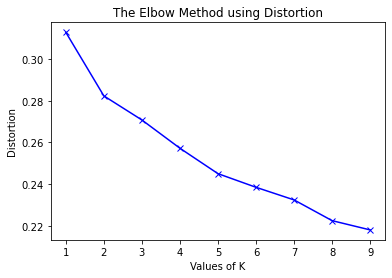

In [15]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

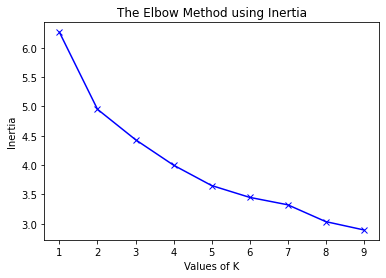

In [16]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

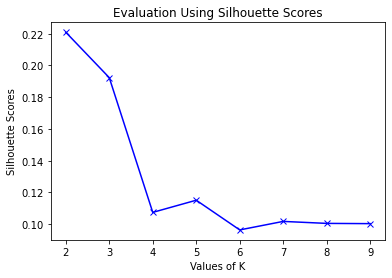

In [17]:
kmeans_per_k = [KMeans(n_clusters=k).fit(br_grouped_clustering) for k in range(1,10)]  
kmeans_per_k
silhouette_scores = [metrics.silhouette_score(br_grouped_clustering, model.labels_) for model in kmeans_per_k[1:]]
plt.plot(range(2,10), silhouette_scores, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Silhouette Scores') 
plt.title('Evaluation Using Silhouette Scores') 
plt.show() 

<h4>Training the model</h4>
<p>These graphs change drastically every time I run the calculations. I went with 3 to stay consistent with the common restaraunts</p>

In [18]:
kclusters = 3
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(br_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

In [19]:
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted['Cluster Labels']=kmeans.labels_

In [20]:
br_merged = br_data

# merge br_grouped with br_data to add latitude/longitude for each neighborhood
br_merged = br_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood').drop_duplicates()
br_merged = pd.merge(br_merged, neighCenterData[['Neighborhood', "Zillow Home Value Index"]], on='Neighborhood')
br_merged.head() # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,1st Most Popular Venue,2nd Most Popular Venue,3rd Most Popular Venue,4th Most Popular Venue,5th Most Popular Venue,6th Most Popular Venue,7th Most Popular Venue,8th Most Popular Venue,9th Most Popular Venue,10th Most Popular Venue,Cluster Labels,Zillow Home Value Index
0,BAKER,30.580547,-91.163706,Fast Food Restaurant,Breakfast Spot,Seafood Restaurant,Fried Chicken Joint,Pizza Place,Bakery,Donut Shop,Diner,Deli / Bodega,Chinese Restaurant,1,95800
1,BOCAGE / CITIPLACE / CONCORD ESTATES,30.418137,-91.119681,Fast Food Restaurant,Breakfast Spot,Tex-Mex Restaurant,Chinese Restaurant,Seafood Restaurant,Sandwich Place,Wings Joint,Cafeteria,Diner,Deli / Bodega,1,233900
2,BROADMOOR,30.444104,-91.080473,Fast Food Restaurant,Fried Chicken Joint,Sandwich Place,Bakery,Burger Joint,Chinese Restaurant,American Restaurant,Snack Place,Tex-Mex Restaurant,Sushi Restaurant,1,176200
3,BROOKSTOWN,30.498502,-91.137226,Fast Food Restaurant,Seafood Restaurant,Breakfast Spot,Donut Shop,Fried Chicken Joint,Burger Joint,Bakery,Bistro,Bagel Shop,BBQ Joint,1,63600
4,BROWNSFIELD,30.570289,-91.118204,Fast Food Restaurant,Seafood Restaurant,Fried Chicken Joint,Pizza Place,Cafeteria,Donut Shop,Diner,Deli / Bodega,Chinese Restaurant,Caribbean Restaurant,1,129900


<h4>Folium Map Creation</h4>
<p>Here we are taking the data generated from our clustering algorithm and displaying it over the map of Baton Rouge. The Chloropleth map indicates the Housing Pricing Index from Zillow</p>

In [23]:
geojson = requests.get('https://opendata.arcgis.com/datasets/7c5e82ef83834de2ad2478efc86744ae_0.geojson').json()
geojsonNotNull = neighCenterData[['Neighborhood', 'Zillow Home Value Index']].dropna()

In [24]:
# create map
map_clusters = folium.Map(location=[brCenterLat, brCenterLong], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
#create the Zillow home value index
folium.Choropleth(
    geo_data=geojson,
    name='choropleth',
    data=geojsonNotNull,
    columns=['Neighborhood', 'Zillow Home Value Index'],
    key_on='feature.properties.NEIGHBORHOOD',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Zillow Housing Index').add_to(map_clusters)

markers_colors = []
for lat, lon, poi, cluster, cost, fir, sec, thi in zip(br_merged['Neighborhood Latitude'],
                                                         br_merged['Neighborhood Longitude'],
                                                         br_merged['Neighborhood'],
                                                         br_merged['Cluster Labels'],
                                                         br_merged['Zillow Home Value Index'],
                                                         br_merged['1st Most Popular Venue'],
                                                         br_merged['2nd Most Popular Venue'],
                                                         br_merged['3rd Most Popular Venue'],):
    labels = [f'{poi}, Cluster {cluster}',
              f'Housing Index: ${cost}',
              'Most Popular Restaurants:',
              f'1) {fir}',
              f'2) {sec}',
              f'3) {thi}']
    nl = '\n'
    label = folium.Popup(f"{nl}{nl.join(labels)}", parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

<h4>View Results</h4>
<p>Here I am sorting the clusters into dataframes based on their cluster labels. The I am creating graphs that show the number of times each Restaurant appears in that cluster.</p>

In [25]:
noextra = br_merged[['Cluster Labels',"1st Most Popular Venue"]]
clust0 = noextra[noextra['Cluster Labels']==0].reset_index()
clust0MostPopList = list(clust0["1st Most Popular Venue"].unique())
y = [clust0.where(clust0["1st Most Popular Venue"]==mostPopular).dropna()["1st Most Popular Venue"].count() for mostPopular in clust0MostPopList]
counts0 = noextra.set_index('Cluster Labels').loc[0].groupby('1st Most Popular Venue').agg(len)
counts0['number']=y

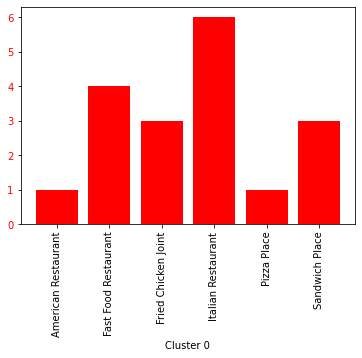

In [26]:
height = counts0['number']
bars = counts0.index
y_pos = np.arange(len(bars))
plt.bar(y_pos, height, color='red' )
plt.figsize=(50,50)
plt.xticks(y_pos, bars, rotation=90)
plt.xlabel('Cluster 0')
plt.yticks(color='red')
plt.show()

In [27]:
clust0DF = br_merged.loc[br_merged['Cluster Labels'] == 0, br_merged.columns[[0] + list(range(3, br_merged.shape[1]))]].sort_values(by='Zillow Home Value Index',ascending=False)
print("Average Home Index: ", clust0DF['Zillow Home Value Index'].mean())
clust0DF 

Average Home Index:  166025.0


,Neighborhood,1st Most Popular Venue,2nd Most Popular Venue,3rd Most Popular Venue,4th Most Popular Venue,5th Most Popular Venue,6th Most Popular Venue,7th Most Popular Venue,8th Most Popular Venue,9th Most Popular Venue,10th Most Popular Venue,Cluster Labels,Zillow Home Value Index
53,UNIVERSITY ACRES / WOODSTONE,Pizza Place,Thai Restaurant,Tex-Mex Restaurant,Bagel Shop,Bakery,Caribbean Restaurant,Restaurant,Café,Burger Joint,Cafeteria,0,286500
6,CITY PARK,Italian Restaurant,American Restaurant,Sandwich Place,Gastropub,Café,Burger Joint,Pizza Place,Sushi Restaurant,Asian Restaurant,Bistro,0,272000
25,KENILWORTH,Pizza Place,Bakery,Italian Restaurant,Sandwich Place,Restaurant,Burrito Place,Diner,Deli / Bodega,Chinese Restaurant,Caribbean Restaurant,0,267200
43,SHENANDOAH,Fried Chicken Joint,Seafood Restaurant,Cajun / Creole Restaurant,Steakhouse,Italian Restaurant,Mexican Restaurant,Fast Food Restaurant,Cafeteria,Diner,Deli / Bodega,0,251600
21,JEFFERSON / DRUSILLA,Sandwich Place,American Restaurant,Bakery,Cajun / Creole Restaurant,Bistro,Pizza Place,BBQ Joint,Fast Food Restaurant,Bagel Shop,Breakfast Spot,0,171600
31,MILLERVILLE,Fast Food Restaurant,Fried Chicken Joint,Breakfast Spot,Greek Restaurant,Cajun / Creole Restaurant,Sandwich Place,Pizza Place,Bakery,Donut Shop,Bistro,0,168800
15,FAIRWOOD,Fried Chicken Joint,Buffet,Food,Deli / Bodega,Italian Restaurant,Pizza Place,Sandwich Place,Noodle House,Fast Food Restaurant,Breakfast Spot,0,161100
48,SOUTH CAMPUS,Fast Food Restaurant,Sandwich Place,Wings Joint,Seafood Restaurant,Greek Restaurant,Cajun / Creole Restaurant,Burrito Place,Pizza Place,Breakfast Spot,Bistro,0,156100
32,MONTICELLO,American Restaurant,Cajun / Creole Restaurant,Fast Food Restaurant,Donut Shop,Chinese Restaurant,Food,Bistro,Breakfast Spot,Buffet,Burger Joint,0,151900
11,DOWNTOWN EAST,American Restaurant,Fast Food Restaurant,Sandwich Place,Cajun / Creole Restaurant,Middle Eastern Restaurant,New American Restaurant,Food,Breakfast Spot,Buffet,Bistro,0,151400


In [28]:
clust1 = noextra[noextra['Cluster Labels']==1].reset_index()
clust1MostPopList = list(clust1["1st Most Popular Venue"].unique())
y = [clust1.where(clust1["1st Most Popular Venue"]==mostPopular).dropna()["1st Most Popular Venue"].count() for mostPopular in clust1MostPopList]
counts1 = noextra.set_index('Cluster Labels').loc[1].groupby('1st Most Popular Venue').agg(len)
counts1['number']=y

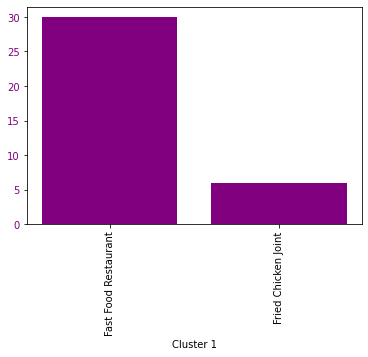

In [29]:
height1 = counts1['number']
bars1 = counts1.index
y_pos1 = np.arange(len(bars1))
plt.bar(y_pos1, height1, color='purple')
plt.figsize=(50,50)
plt.xticks(y_pos1, bars1, rotation=90)
plt.yticks(color='purple')
plt.xlabel('Cluster 1')
plt.show()

In [30]:
clust1DF = br_merged.loc[br_merged['Cluster Labels'] == 1, br_merged.columns[[0] + list(range(3, br_merged.shape[1]))]].sort_values(by='Zillow Home Value Index',ascending=False)
print("Average Home Index: ", clust1DF['Zillow Home Value Index'].mean())
clust1DF 

Average Home Index:  192875.0


,Neighborhood,1st Most Popular Venue,2nd Most Popular Venue,3rd Most Popular Venue,4th Most Popular Venue,5th Most Popular Venue,6th Most Popular Venue,7th Most Popular Venue,8th Most Popular Venue,9th Most Popular Venue,10th Most Popular Venue,Cluster Labels,Zillow Home Value Index
46,SOUTH BLUEBONNET / NICHOLSON,Fast Food Restaurant,Burger Joint,Fried Chicken Joint,Restaurant,Mexican Restaurant,American Restaurant,Steakhouse,Southern / Soul Food Restaurant,Thai Restaurant,Chinese Restaurant,1,443400
39,POLLARD / WOODCHASE,Fast Food Restaurant,Seafood Restaurant,Chinese Restaurant,Pizza Place,Restaurant,Fried Chicken Joint,Sushi Restaurant,Thai Restaurant,Bagel Shop,Cafeteria,1,364750
26,KLEINPETER,Fast Food Restaurant,American Restaurant,Steakhouse,Mexican Restaurant,Restaurant,Burger Joint,Bakery,Bistro,Breakfast Spot,Buffet,1,358800
49,SOUTHSIDE,Fast Food Restaurant,Burger Joint,Tex-Mex Restaurant,BBQ Joint,Chinese Restaurant,Seafood Restaurant,Breakfast Spot,Mexican Restaurant,Café,Diner,1,339500
38,PERKINS / HIGHLAND,Fast Food Restaurant,Wings Joint,Seafood Restaurant,Bistro,Breakfast Spot,Restaurant,Fried Chicken Joint,American Restaurant,Steakhouse,Burger Joint,1,285400
7,COLLEGE TOWN,Fast Food Restaurant,Pizza Place,Asian Restaurant,Bakery,Chinese Restaurant,Mexican Restaurant,Restaurant,Burrito Place,Café,Diner,1,276900
51,TARA,Fast Food Restaurant,Bakery,Fried Chicken Joint,Sandwich Place,Burger Joint,American Restaurant,Southern / Soul Food Restaurant,Snack Place,Deli / Bodega,Chinese Restaurant,1,271700
57,ZACHARY,Fast Food Restaurant,Fried Chicken Joint,Restaurant,Mediterranean Restaurant,American Restaurant,Sushi Restaurant,Steakhouse,Burger Joint,Deli / Bodega,Chinese Restaurant,1,250000
18,GOODWOOD,Fast Food Restaurant,Fried Chicken Joint,Cafeteria,BBQ Joint,Seafood Restaurant,Sandwich Place,Mexican Restaurant,Diner,Deli / Bodega,Chinese Restaurant,1,240900
23,JEFFERSON TERRACE / INNISWOLD,Fast Food Restaurant,Burger Joint,Steakhouse,Italian Restaurant,Breakfast Spot,American Restaurant,BBQ Joint,Bakery,Bistro,Bagel Shop,1,240300


In [31]:
clust2 = noextra[noextra['Cluster Labels']==2].reset_index()
clust2MostPopList = list(clust2["1st Most Popular Venue"].unique())
y2 = [clust2.where(clust2["1st Most Popular Venue"]==mostPopular).dropna()["1st Most Popular Venue"].count() for mostPopular in clust2MostPopList]
counts2 = noextra.set_index('Cluster Labels').loc[2].groupby('1st Most Popular Venue').agg(len)
counts2['number']=y2

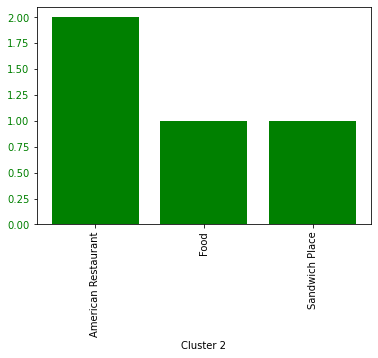

In [32]:
height2 = counts2['number']
bars2 = counts2.index
y_pos2 = np.arange(len(bars2))
plt.bar(y_pos2, height2, color='green')
plt.figsize=(50,50)
plt.xticks(y_pos2, bars2, rotation=90)
plt.yticks(color='green')
plt.xlabel('Cluster 2')
plt.show()

In [33]:
clust2DF = br_merged.loc[br_merged['Cluster Labels'] == 2, br_merged.columns[[0] + list(range(3, br_merged.shape[1]))]].sort_values(by='Zillow Home Value Index',ascending=False)
print("Average Home Index: ", clust2DF['Zillow Home Value Index'].mean())
clust2DF 

Average Home Index:  66175.0


,Neighborhood,1st Most Popular Venue,2nd Most Popular Venue,3rd Most Popular Venue,4th Most Popular Venue,5th Most Popular Venue,6th Most Popular Venue,7th Most Popular Venue,8th Most Popular Venue,9th Most Popular Venue,10th Most Popular Venue,Cluster Labels,Zillow Home Value Index
12,EAST FAIRFIELDS / MELROSE PLACE,Food,American Restaurant,Fast Food Restaurant,Bakery,Seafood Restaurant,BBQ Joint,Café,Donut Shop,Diner,Deli / Bodega,2,144700
14,FAIRFIELDS,American Restaurant,Bakery,Snack Place,Food,Cafeteria,Donut Shop,Diner,Deli / Bodega,Chinese Restaurant,Caribbean Restaurant,2,56800
45,SMILEY HEIGHTS / MELROSE EAST,Sandwich Place,Food,Deli / Bodega,Bakery,Chinese Restaurant,Wings Joint,Cafeteria,Donut Shop,Diner,Caribbean Restaurant,2,33100
13,EDEN PARK,Food,Seafood Restaurant,Wings Joint,Cafeteria,Donut Shop,Diner,Deli / Bodega,Chinese Restaurant,Caribbean Restaurant,Cajun / Creole Restaurant,2,30100
